In [1]:
import pandas as pd
import numpy as np
import math
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import cross_validate, cross_val_predict, StratifiedKFold

from sklearn.feature_selection import SelectFromModel
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import make_scorer

from imblearn.over_sampling import SMOTE

from sklearn.metrics import RocCurveDisplay

In [2]:
ott_stream = pd.read_csv("data/ott_churn_model_dataset.csv")

In [3]:
ott_stream.head()

,year,customer_id,phone_no,gender,age,no_of_days_subscribed,multi_screen,mail_subscribed,weekly_mins_watched,minimum_daily_mins,maximum_daily_mins,weekly_max_night_mins,videos_watched,maximum_days_inactive,customer_support_calls,churn
0,2020,100198,409-8743,Female,36,62,no,no,148.35,12.2,16.81,82,1,4.0,1,0.0
1,2020,100643,340-5930,Female,39,149,no,no,294.45,7.7,33.37,87,3,3.0,2,0.0
2,2020,100756,372-3750,Female,65,126,no,no,87.30,11.9,9.89,91,1,4.0,5,1.0
3,2020,101595,331-4902,Female,24,131,no,yes,321.30,9.5,36.41,102,4,3.0,3,0.0
4,2020,101653,351-8398,Female,40,191,no,no,243.00,10.9,27.54,83,7,3.0,1,0.0


In [4]:
ott_stream.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year                    2000 non-null   int64  
 1   customer_id             2000 non-null   int64  
 2   phone_no                2000 non-null   object 
 3   gender                  1976 non-null   object 
 4   age                     2000 non-null   int64  
 5   no_of_days_subscribed   2000 non-null   int64  
 6   multi_screen            2000 non-null   object 
 7   mail_subscribed         2000 non-null   object 
 8   weekly_mins_watched     2000 non-null   float64
 9   minimum_daily_mins      2000 non-null   float64
 10  maximum_daily_mins      2000 non-null   float64
 11  weekly_max_night_mins   2000 non-null   int64  
 12  videos_watched          2000 non-null   int64  
 13  maximum_days_inactive   1972 non-null   float64
 14  customer_support_calls  2000 non-null   

In [5]:
ott_stream.isna().sum()

year                       0
customer_id                0
phone_no                   0
gender                    24
age                        0
no_of_days_subscribed      0
multi_screen               0
mail_subscribed            0
weekly_mins_watched        0
minimum_daily_mins         0
maximum_daily_mins         0
weekly_max_night_mins      0
videos_watched             0
maximum_days_inactive     28
customer_support_calls     0
churn                     35
dtype: int64

In [6]:
ott_stream.dropna(subset = ['gender', 'churn'], inplace=True)

In [7]:
print('Raw counts: \n')
print(ott_stream['churn'].value_counts())
print('-----------------------------------')
print('Normalized counts: \n')
print(ott_stream['churn'].value_counts(normalize=True))

Raw counts: 

0.0    1681
1.0     260
Name: churn, dtype: int64
-----------------------------------
Normalized counts: 

0.0    0.866048
1.0    0.133952
Name: churn, dtype: float64


The dataset is imbalanced, meaning that the split between the target variable, churn, is not 50/50. This means that without any preprocessing steps, one can assume that the probability of predicting whether a customer will not churn is roughly 87%. To adjust for this, it will be important to apply SMOTE to either undersample or oversample.

In [8]:
y = ott_stream['churn']
X = ott_stream.drop(['churn', 'year', 'customer_id', 'phone_no'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [9]:
X_train_numeric = X_train.select_dtypes(exclude = ['object'])
X_train_numeric.columns

Index(['age', 'no_of_days_subscribed', 'weekly_mins_watched',
       'minimum_daily_mins', 'maximum_daily_mins', 'weekly_max_night_mins',
       'videos_watched', 'maximum_days_inactive', 'customer_support_calls'],
      dtype='object')

In [10]:
X_train_numeric['maximum_days_inactive'].describe()

count    1435.000000
mean        3.252962
std         0.797999
min         0.000000
25%         3.000000
50%         3.000000
75%         4.000000
max         6.000000
Name: maximum_days_inactive, dtype: float64

The column 'maximum_days_inactive' contains discrete values that represent full days a user is inactive. The mean is close enough to the median (50th percentile) such that we can impute the median to the missing rows in order to get a more representative value for the column.

In [11]:
max_days_median = X_train_numeric['maximum_days_inactive'].median()
X_train_numeric['maximum_days_inactive'].fillna(max_days_median, inplace=True)

X_train_numeric.isna().sum()

age                       0
no_of_days_subscribed     0
weekly_mins_watched       0
minimum_daily_mins        0
maximum_daily_mins        0
weekly_max_night_mins     0
videos_watched            0
maximum_days_inactive     0
customer_support_calls    0
dtype: int64

We have addressed all the NaN values in the numeric columns. Next, we scale the numerical columns to use for logistic regression and so that the degree of predictor importance can be assessed later on. 

In [12]:
scaler = MinMaxScaler()

scaler.fit(X_train_numeric)
X_train_scaled = pd.DataFrame(
    scaler.transform(X_train_numeric),
    # index is important to ensure we can concatenate with other columns
    index=X_train_numeric.index,
    columns=X_train_numeric.columns
)
X_train_scaled

,age,no_of_days_subscribed,weekly_mins_watched,minimum_daily_mins,maximum_daily_mins,weekly_max_night_mins,videos_watched,maximum_days_inactive,customer_support_calls
289,0.187500,0.121212,0.435987,0.465,0.436021,0.375940,0.105263,0.500000,0.111111
1725,0.312500,0.554113,0.573345,0.740,0.573413,0.563910,0.473684,0.666667,0.222222
833,0.640625,0.757576,0.708661,0.480,0.708576,0.323308,0.315789,0.500000,0.222222
982,0.390625,0.043290,0.532808,0.300,0.532762,0.285714,0.157895,0.333333,0.333333
1801,0.109375,0.627706,0.364829,0.560,0.364837,0.646617,0.157895,0.666667,0.111111
...,...,...,...,...,...,...,...,...,...
1180,0.437500,0.372294,0.464859,0.550,0.464837,0.345865,0.315789,0.500000,0.111111
1344,0.234375,0.406926,0.388451,0.295,0.388508,0.639098,0.315789,0.333333,0.333333
907,0.234375,0.281385,0.426072,0.475,0.426072,0.436090,0.157895,0.500000,0.444444
1514,0.609375,0.497835,0.714786,0.590,0.714751,0.466165,0.157895,0.666667,0.222222


In [13]:
X_train_categorical = X_train.select_dtypes(include = ['object'])
X_train_categorical.columns

Index(['gender', 'multi_screen', 'mail_subscribed'], dtype='object')

In [14]:
X_train_categorical.head()

,gender,multi_screen,mail_subscribed
289,Male,no,no
1725,Female,no,yes
833,Male,no,no
982,Male,no,yes
1801,Male,yes,no


An assessment of the categorical columns shows that gender, multi_screen, and mail_subscribed all function as boolean varibales (either Male/Female, or yes/no), and can therefore be converted to binary values (0, 1)

In [15]:
mapping1 = {'Female': 1, 'Male': 0}
mapping2 = {'yes': 1, 'no': 0}

X_train_categorical['gender'] = X_train_categorical['gender'].map(mapping1)

X_train_categorical['multi_screen'] = X_train_categorical['multi_screen'].map(mapping2)

X_train_categorical['mail_subscribed'] = X_train_categorical['mail_subscribed'].map(mapping2)

X_train_categorical.head()

,gender,multi_screen,mail_subscribed
289,0,0,0
1725,1,0,1
833,0,0,0
982,0,0,1
1801,0,1,0


Concatenate the numeric and categorical columns into a new dataframe that is ready for additional preprocessing and modeling.

In [16]:
X_train_full = pd.concat([X_train_scaled, X_train_categorical], axis=1)
X_train_full.head()

,age,no_of_days_subscribed,weekly_mins_watched,minimum_daily_mins,maximum_daily_mins,weekly_max_night_mins,videos_watched,maximum_days_inactive,customer_support_calls,gender,multi_screen,mail_subscribed
289,0.187500,0.121212,0.435987,0.465,0.436021,0.375940,0.105263,0.500000,0.111111,0,0,0
1725,0.312500,0.554113,0.573345,0.740,0.573413,0.563910,0.473684,0.666667,0.222222,1,0,1
833,0.640625,0.757576,0.708661,0.480,0.708576,0.323308,0.315789,0.500000,0.222222,0,0,0
982,0.390625,0.043290,0.532808,0.300,0.532762,0.285714,0.157895,0.333333,0.333333,0,0,1
1801,0.109375,0.627706,0.364829,0.560,0.364837,0.646617,0.157895,0.666667,0.111111,0,1,0


Repeat these steps for the X_test data to ensure that the model is tested using the same units as it was trained.

In [17]:
X_test_numeric = X_test.select_dtypes(exclude = ['object'])

max_days_median2 = X_test_numeric['maximum_days_inactive'].median()
X_test_numeric['maximum_days_inactive'].fillna(max_days_median2, inplace=True)

X_test_numeric.isna().sum()

age                       0
no_of_days_subscribed     0
weekly_mins_watched       0
minimum_daily_mins        0
maximum_daily_mins        0
weekly_max_night_mins     0
videos_watched            0
maximum_days_inactive     0
customer_support_calls    0
dtype: int64

In [18]:
scaler.fit(X_test_numeric)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_numeric),
    index=X_test_numeric.index,
    columns=X_test_numeric.columns
)
X_test_scaled

,age,no_of_days_subscribed,weekly_mins_watched,minimum_daily_mins,maximum_daily_mins,weekly_max_night_mins,videos_watched,maximum_days_inactive,customer_support_calls
1660,0.396552,0.198347,0.767878,0.760870,0.767809,0.482759,0.111111,0.8,0.250
1557,0.862069,0.268595,0.340254,0.288043,0.340231,0.689655,0.277778,0.4,0.125
76,0.224138,0.181818,0.460784,0.576087,0.460821,0.439655,0.166667,0.6,0.250
1026,0.310345,0.272727,0.373702,0.788043,0.373643,0.439655,0.277778,0.8,0.125
1102,0.379310,0.438017,0.385813,0.483696,0.385855,0.629310,0.222222,0.6,0.000
...,...,...,...,...,...,...,...,...,...
1037,0.120690,0.165289,0.691465,0.396739,0.691486,0.500000,0.055556,0.4,0.250
789,0.068966,0.351240,0.361880,0.483696,0.361940,0.586207,0.444444,0.6,0.125
606,0.241379,0.107438,0.512111,0.413043,0.512042,0.551724,0.166667,0.6,0.375
219,0.482759,0.231405,0.681949,0.663043,0.681988,0.646552,0.166667,0.8,0.250


In [19]:
X_test_categorical = X_test.select_dtypes(include = ['object'])

In [20]:
X_test_categorical['gender'] = X_test_categorical['gender'].map(mapping1)

X_test_categorical['multi_screen'] = X_test_categorical['multi_screen'].map(mapping2)

X_test_categorical['mail_subscribed'] = X_test_categorical['mail_subscribed'].map(mapping2)

X_test_categorical.head()

,gender,multi_screen,mail_subscribed
1660,1,0,0
1557,0,0,0
76,0,0,0
1026,0,0,1
1102,0,0,0


In [21]:
X_test_full = pd.concat([X_test_scaled, X_test_categorical], axis=1)
X_test_full.head()

,age,no_of_days_subscribed,weekly_mins_watched,minimum_daily_mins,maximum_daily_mins,weekly_max_night_mins,videos_watched,maximum_days_inactive,customer_support_calls,gender,multi_screen,mail_subscribed
1660,0.396552,0.198347,0.767878,0.760870,0.767809,0.482759,0.111111,0.8,0.250,1,0,0
1557,0.862069,0.268595,0.340254,0.288043,0.340231,0.689655,0.277778,0.4,0.125,0,0,0
76,0.224138,0.181818,0.460784,0.576087,0.460821,0.439655,0.166667,0.6,0.250,0,0,0
1026,0.310345,0.272727,0.373702,0.788043,0.373643,0.439655,0.277778,0.8,0.125,0,0,1
1102,0.379310,0.438017,0.385813,0.483696,0.385855,0.629310,0.222222,0.6,0.000,0,0,0


Next, observe the correlation matrix for the independent variables as they relate to churn and drop any variables that appear to be collinear with another variable.

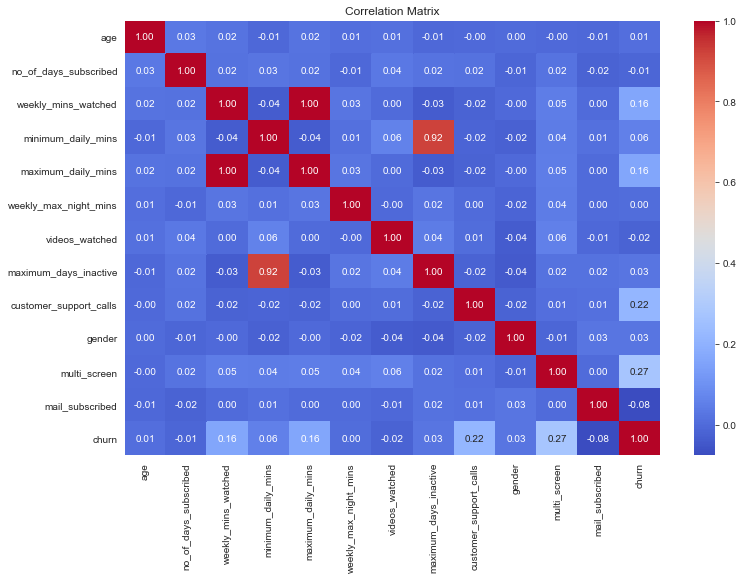

In [22]:
correl_data = pd.concat([X_train_full, y_train], axis=1)

# Compute the correlation matrix
correlation_matrix = correl_data.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

It appears that 'maximum_daily_mins' and 'minimum_daily_mins' are highly correlated with other variables, so drop them to ensure that predictors are relatively independent.

In [23]:
X_train_full = X_train_full.drop(['minimum_daily_mins', 'maximum_daily_mins'], axis=1)
X_test_full = X_test_full.drop(['minimum_daily_mins', 'maximum_daily_mins'], axis=1)

Appropriate features have been selected and engineered, and the data is ready for initial modeling. Begin by running a basic logistic regression to generate a baseline upon which to improve.

In [24]:
logreg1 = LogisticRegression(random_state = 42, penalty = None, max_iter = 5000)
logreg1.fit(X_train_full, y_train)

LogisticRegression(max_iter=5000, penalty=None, random_state=42)

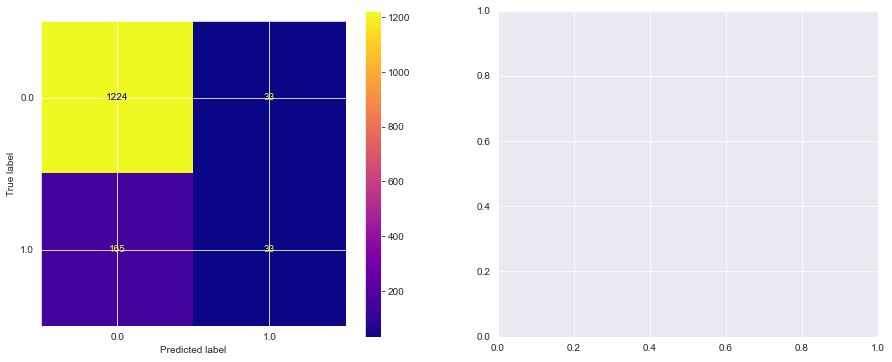

In [25]:
fix, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

ConfusionMatrixDisplay.from_estimator(logreg1, X_train_full, y_train, ax=axes[0], cmap="plasma")

The true negative count seems to be relatively high, but there seem to be a lot of false negatives. Run this model on the test set to observe its preformance.

Accuracy: 0.86
Precision: 0.39
Recall: 0.18
f1 Score: 0.24


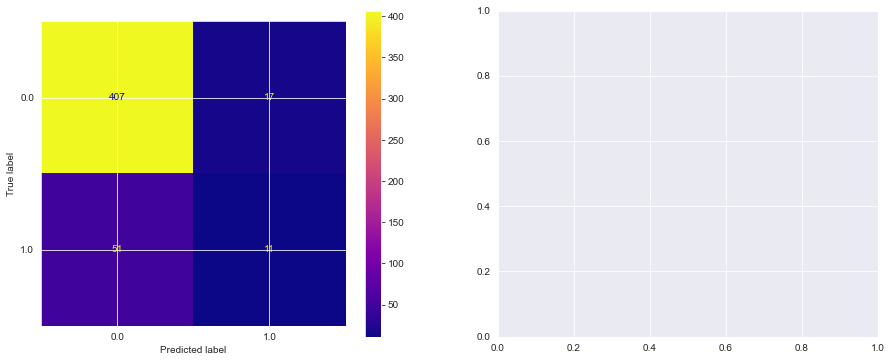

In [26]:
y_pred = logreg1.predict(X_test_full)

fix, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

ConfusionMatrixDisplay.from_estimator(logreg1, X_test_full, y_test, ax=axes[0], cmap="plasma")

print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
print(f'Precision: {precision_score(y_test, y_pred):.2f}')
print(f'Recall: {recall_score(y_test, y_pred):.2f}')
print(f'f1 Score: {f1_score(y_test, y_pred):.2f}')

The model performed well on accuracy, but poorly on all other metrics. Because this data set was imbalanced and the majority of observations contained no churn (86%), this model essentially performed as well as the original baseline when randomly selecting. 

Within this context, it will be important to maximize for recall, or minimizing the amount of false negatives. False negatives represent customers who were predicted not to churn, but who do actually churn. In order for a streaming service to optimize customer retention, the most valuable model should have a high recall that identifies customers that have even a slight probability of churning. There are many methods that can be applied to produce this type of model, including SMOTE, regularization, and threshold adjustment. 

Begin by comparing some models with varying regularization weights:

LogisticRegression(C=1e+20, fit_intercept=False)
AUC for None: 0.6887172854534388
-------------------------------------------------------------------------------------
LogisticRegression(C=1e+20, class_weight='balanced', fit_intercept=False)
AUC for Balanced: 0.743837492391966
-------------------------------------------------------------------------------------
LogisticRegression(C=1e+20, class_weight={0: 1, 1: 2}, fit_intercept=False)
AUC for 2 to 1: 0.7137096774193548
-------------------------------------------------------------------------------------
LogisticRegression(C=1e+20, class_weight={0: 1, 1: 10}, fit_intercept=False)
AUC for 10 to 1: 0.7524726110772976
-------------------------------------------------------------------------------------
LogisticRegression(C=1e+20, class_weight={0: 1, 1: 100}, fit_intercept=False)
AUC for 100 to 1: 0.7764379184418746
-------------------------------------------------------------------------------------
LogisticRegression(C=1e+20, class_weigh

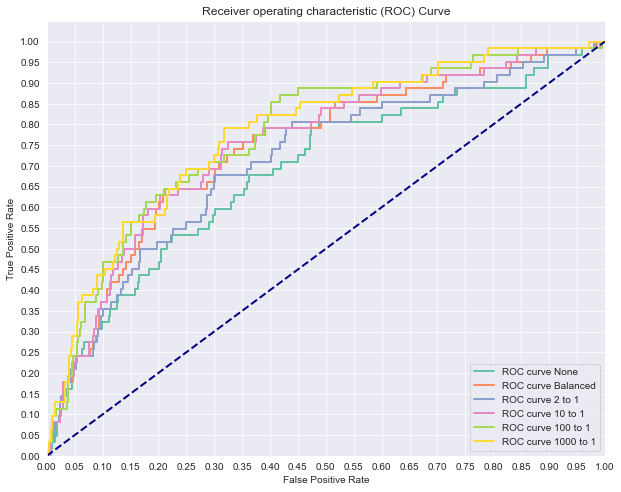

In [27]:
# Now let's compare a few different regularization performances on the dataset:
weights = [None, 'balanced', {1:2, 0:1}, {1:10, 0:1}, {1:100, 0:1}, {1:1000, 0:1}]
names = ['None', 'Balanced', '2 to 1', '10 to 1', '100 to 1', '1000 to 1']
colors = sns.color_palette('Set2')

plt.figure(figsize=(10,8))

for n, weight in enumerate(weights):
    # Fit a model
    logreg2 = LogisticRegression(fit_intercept=False, C=1e20, class_weight=weight, solver='lbfgs')
    model_log = logreg2.fit(X_train_full, y_train)
    print(model_log)

    # Predict
    y_hat_test2 = logreg2.predict(X_test_full)

    y_score2 = logreg2.fit(X_train_full, y_train).decision_function(X_test_full)

    fpr, tpr, thresholds = roc_curve(y_test, y_score2)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------------------------------------')
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

As seen by the improvement in AUC for ROCs as the class weight increases, balancing the weights will have a significant affect on the model performance (.69 AUC to .78 AUC). Next, oversample the minority class and compare improvements in ROC curves to the scenarios presented above.

LogisticRegression(C=1e+20, fit_intercept=False)
AUC for 0.5: 0.720899269628728
-------------------------------------------------------------------------------------
LogisticRegression(C=1e+20, fit_intercept=False)
AUC for 0.75: 0.7262629336579428
-------------------------------------------------------------------------------------
LogisticRegression(C=1e+20, fit_intercept=False)
AUC for 0.9: 0.7374087035909921
-------------------------------------------------------------------------------------
LogisticRegression(C=1e+20, fit_intercept=False)
AUC for 0.95: 0.7377510651247717
-------------------------------------------------------------------------------------
LogisticRegression(C=1e+20, fit_intercept=False)
AUC for 1.0: 0.7399193548387096
-------------------------------------------------------------------------------------


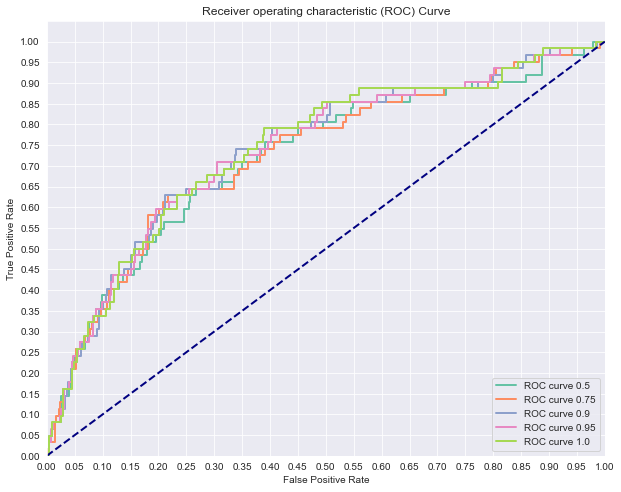

In [28]:
# Now let's compare a few different ratios of minority class to majority class
ratios = [0.5, 0.75, 0.9, 0.95, 1.0]  
names = ['0.5', '0.75', '0.9', '0.95', '1.0']
colors = sns.color_palette('Set2')

plt.figure(figsize=(10, 8))

for n, ratio in enumerate(ratios):
    # Fit a model
    smote = SMOTE(sampling_strategy=ratio)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_full, y_train) 
    logreg3 = LogisticRegression(fit_intercept=False, C=1e20, solver ='lbfgs')
    model_log2 = logreg3.fit(X_train_resampled, y_train_resampled)
    print(model_log2)

    # Predict
    y_hat_test3 = logreg3.predict(X_test_full)

    y_score3 = logreg3.decision_function(X_test_full)

    fpr, tpr, thresholds = roc_curve(y_test, y_score3)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------------------------------------')
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

The best performing ROC curve when applying SMOTE occurred at sampling strategy ratio = .9, so reconfigure your training set to synthetically oversample the minority class with this ration:

In [29]:
print('Original class distribution: \n')
print(y.value_counts())
smote = SMOTE(sampling_strategy=.9)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_full, y_train) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts())

Original class distribution: 

0.0    1681
1.0     260
Name: churn, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

0.0    1257
1.0    1131
Name: churn, dtype: int64


Run a new logistic regression model using the resampled X_train and y_train data to see if the model performance improved:

In [30]:
logreg4 = LogisticRegression(random_state = 42, penalty = None, max_iter = 5000)
logreg4.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=5000, penalty=None, random_state=42)

Accuracy: 0.69136
Precision: 0.25281
Recall: 0.72581
f1 Score: 0.37500


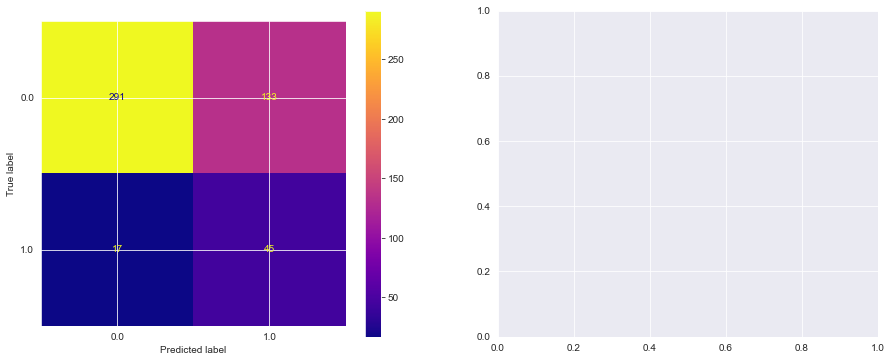

In [31]:
y_pred2 = logreg4.predict(X_test_full)

fix, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

ConfusionMatrixDisplay.from_estimator(logreg4, X_test_full, y_test, ax=axes[0], cmap="plasma")

print(f'Accuracy: {accuracy_score(y_test, y_pred2):.5f}')
print(f'Precision: {precision_score(y_test, y_pred2):.5f}')
print(f'Recall: {recall_score(y_test, y_pred2):.5f}')
print(f'f1 Score: {f1_score(y_test, y_pred2):.5f}')

Although accuracy dropped, recall dramatically improved (from .18 to .73) and the f1 score, which measures the overall model, improved (from .24 to .39). Although less accurate, this model optimizes for the most important metric, minimizing false negatives, when compared to the baseline. There was no penalty applied to this model. Let's see if the model's performance improves when applying both L1 lasso and L2 ridge penalties: 

Accuracy: 0.69342
Precision: 0.25143
Recall: 0.70968
f1 Score: 0.37131


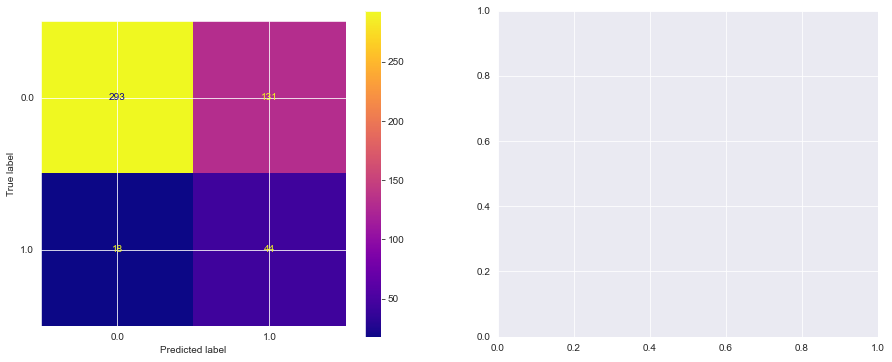

In [32]:
logreg5 = LogisticRegression(random_state = 42, penalty = 'l2', max_iter = 5000)
logreg5.fit(X_train_resampled, y_train_resampled)

y_pred3 = logreg5.predict(X_test_full)

fix, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

ConfusionMatrixDisplay.from_estimator(logreg5, X_test_full, y_test, ax=axes[0], cmap="plasma")

print(f'Accuracy: {accuracy_score(y_test, y_pred3):.5f}')
print(f'Precision: {precision_score(y_test, y_pred3):.5f}')
print(f'Recall: {recall_score(y_test, y_pred3):.5f}')
print(f'f1 Score: {f1_score(y_test, y_pred3):.5f}')

Accuracy: 0.70165
Precision: 0.26286
Recall: 0.74194
F1 Score: 0.38819


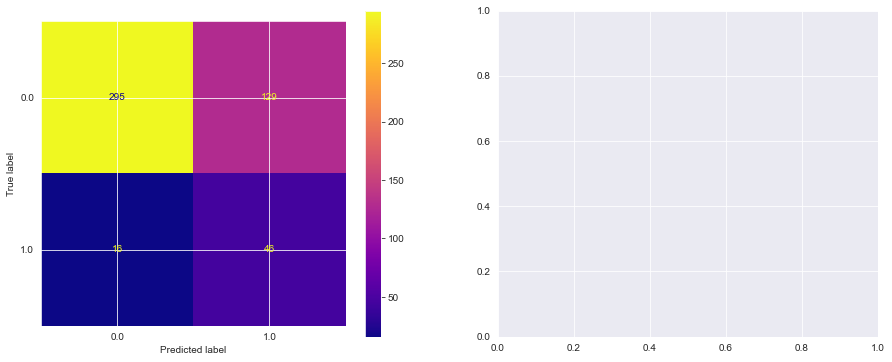

In [33]:
logreg6 = LogisticRegression(random_state=42, penalty='l1', solver='saga', max_iter=5000)
logreg6.fit(X_train_resampled, y_train_resampled)

y_pred4 = logreg6.predict(X_test_full)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

ConfusionMatrixDisplay.from_estimator(logreg6, X_test_full, y_test, ax=axes[0], cmap="plasma")

print(f'Accuracy: {accuracy_score(y_test, y_pred4):.5f}')
print(f'Precision: {precision_score(y_test, y_pred4):.5f}')
print(f'Recall: {recall_score(y_test, y_pred4):.5f}')
print(f'F1 Score: {f1_score(y_test, y_pred4):.5f}')

Although adding penalties made almost no difference with regard to recall, applying the L1 lasso penalty marginally improved the f1 score for the model. 

In [34]:
X_quad_train = X_train_resampled.copy()
poly = PolynomialFeatures(4)
X_poly_train = poly.fit_transform(X_quad_train)

X_quad_test = X_test_full.copy()
X_poly_test = poly.fit_transform(X_quad_test)

pd.DataFrame(X_poly_test)
pd.DataFrame(X_poly_train)

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
0,1.0,0.187500,0.121212,0.435987,0.375940,0.105263,0.500000,0.111111,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.312500,0.554113,0.573345,0.563910,0.473684,0.666667,0.222222,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.640625,0.757576,0.708661,0.323308,0.315789,0.500000,0.222222,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.390625,0.043290,0.532808,0.285714,0.157895,0.333333,0.333333,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.109375,0.627706,0.364829,0.646617,0.157895,0.666667,0.111111,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2383,1.0,0.412030,0.884761,0.570682,0.432632,0.196141,0.500000,0.040371,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2384,1.0,0.294541,0.284171,0.789477,0.480080,0.172415,0.570883,0.047255,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2385,1.0,0.324624,0.595783,0.685172,0.588568,0.115595,0.500000,0.000000,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2386,1.0,0.519384,0.364047,0.450103,0.582085,0.167887,0.515821,0.576650,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Accuracy: 0.82305
Precision: 0.40323
Recall: 0.80645
F1 Score: 0.53763


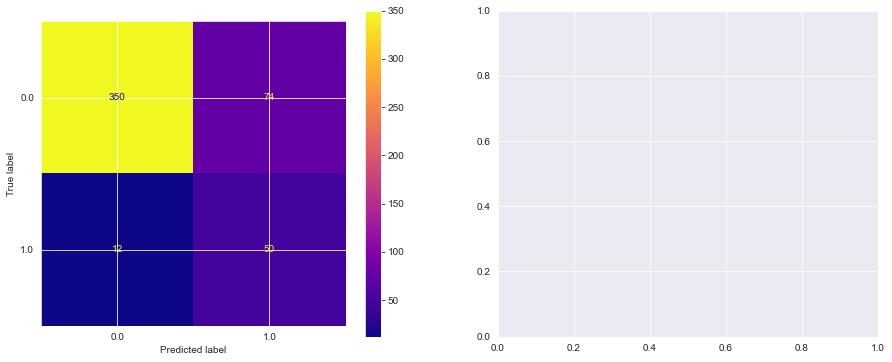

In [35]:
logreg7 = LogisticRegression(random_state=42, penalty='l1', solver='saga', max_iter=5000)
logreg7.fit(X_poly_train, y_train_resampled)

y_pred5 = logreg7.predict(X_poly_test)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

ConfusionMatrixDisplay.from_estimator(logreg7, X_poly_test, y_test, ax=axes[0], cmap="plasma")

print(f'Accuracy: {accuracy_score(y_test, y_pred5):.5f}')
print(f'Precision: {precision_score(y_test, y_pred5):.5f}')
print(f'Recall: {recall_score(y_test, y_pred5):.5f}')
print(f'F1 Score: {f1_score(y_test, y_pred5):.5f}')

In [36]:
X_cube_train = X_train_resampled.copy()
poly3 = PolynomialFeatures(3)
X_poly3_train = poly3.fit_transform(X_cube_train)

X_cube_test = X_test_full.copy()
X_poly3_test = poly3.fit_transform(X_cube_test)

pd.DataFrame(X_poly3_test)
pd.DataFrame(X_poly3_train)

,0,1,2,3,4,5,6,7,8,9,...,276,277,278,279,280,281,282,283,284,285
0,1.0,0.187500,0.121212,0.435987,0.375940,0.105263,0.500000,0.111111,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.312500,0.554113,0.573345,0.563910,0.473684,0.666667,0.222222,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,1.0,0.640625,0.757576,0.708661,0.323308,0.315789,0.500000,0.222222,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.390625,0.043290,0.532808,0.285714,0.157895,0.333333,0.333333,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.109375,0.627706,0.364829,0.646617,0.157895,0.666667,0.111111,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2383,1.0,0.412030,0.884761,0.570682,0.432632,0.196141,0.500000,0.040371,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2384,1.0,0.294541,0.284171,0.789477,0.480080,0.172415,0.570883,0.047255,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2385,1.0,0.324624,0.595783,0.685172,0.588568,0.115595,0.500000,0.000000,1.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2386,1.0,0.519384,0.364047,0.450103,0.582085,0.167887,0.515821,0.576650,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Accuracy: 0.80864
Precision: 0.38168
Recall: 0.80645
F1 Score: 0.51813


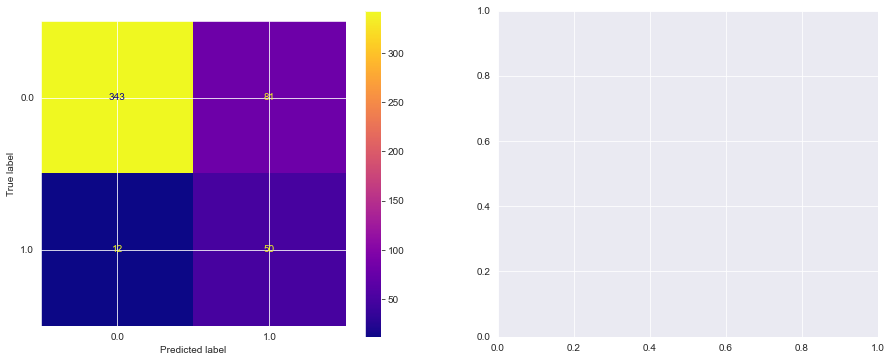

In [37]:
logreg8 = LogisticRegression(random_state=42, penalty='l1', solver='saga', max_iter=5000)
logreg8.fit(X_poly3_train, y_train_resampled)

y_pred6 = logreg8.predict(X_poly3_test)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

ConfusionMatrixDisplay.from_estimator(logreg8, X_poly3_test, y_test, ax=axes[0], cmap="plasma")

print(f'Accuracy: {accuracy_score(y_test, y_pred6):.5f}')
print(f'Precision: {precision_score(y_test, y_pred6):.5f}')
print(f'Recall: {recall_score(y_test, y_pred6):.5f}')
print(f'F1 Score: {f1_score(y_test, y_pred6):.5f}')

In [38]:
X_sq_train = X_train_resampled.copy()
poly2 = PolynomialFeatures(2)
X_poly2_train = poly2.fit_transform(X_sq_train)

X_sq_test = X_test_full.copy()
X_poly2_test = poly2.fit_transform(X_sq_test)

pd.DataFrame(X_poly2_test)
pd.DataFrame(X_poly2_train)

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
0,1.0,0.187500,0.121212,0.435987,0.375940,0.105263,0.500000,0.111111,0.0,0.0,...,0.012346,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.312500,0.554113,0.573345,0.563910,0.473684,0.666667,0.222222,1.0,0.0,...,0.049383,0.222222,0.000000,0.222222,1.0,0.0,1.0,0.0,0.0,1.0
2,1.0,0.640625,0.757576,0.708661,0.323308,0.315789,0.500000,0.222222,0.0,0.0,...,0.049383,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.390625,0.043290,0.532808,0.285714,0.157895,0.333333,0.333333,0.0,0.0,...,0.111111,0.000000,0.000000,0.333333,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.109375,0.627706,0.364829,0.646617,0.157895,0.666667,0.111111,0.0,1.0,...,0.012346,0.000000,0.111111,0.000000,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2383,1.0,0.412030,0.884761,0.570682,0.432632,0.196141,0.500000,0.040371,1.0,0.0,...,0.001630,0.040371,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0
2384,1.0,0.294541,0.284171,0.789477,0.480080,0.172415,0.570883,0.047255,0.0,0.0,...,0.002233,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2385,1.0,0.324624,0.595783,0.685172,0.588568,0.115595,0.500000,0.000000,1.0,1.0,...,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.0,1.0,0.0,0.0
2386,1.0,0.519384,0.364047,0.450103,0.582085,0.167887,0.515821,0.576650,0.0,0.0,...,0.332525,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


Accuracy: 0.79630
Precision: 0.37241
Recall: 0.87097
F1 Score: 0.52174


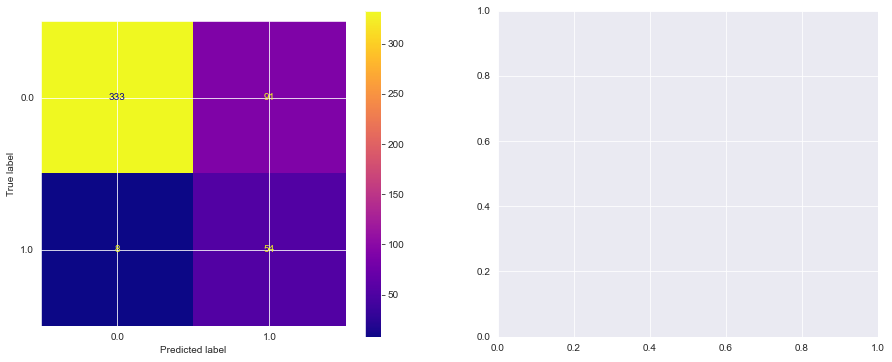

In [39]:
logreg9 = LogisticRegression(random_state=42, penalty='l1', solver='saga', max_iter=5000)
logreg9.fit(X_poly2_train, y_train_resampled)

y_pred7 = logreg9.predict(X_poly2_test)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

ConfusionMatrixDisplay.from_estimator(logreg9, X_poly2_test, y_test, ax=axes[0], cmap="plasma")

print(f'Accuracy: {accuracy_score(y_test, y_pred7):.5f}')
print(f'Precision: {precision_score(y_test, y_pred7):.5f}')
print(f'Recall: {recall_score(y_test, y_pred7):.5f}')
print(f'F1 Score: {f1_score(y_test, y_pred7):.5f}')

When applying polynomial feature transformation, a square transformation appeared to produce the best results with regard to accuracy, recall, and f1-score improvement, while maintaining a reasonable (though difficult to inrepret) amount of columns (66). For the purpose of optimizing the model, move forward with cross validation using the recall metric on this squared transformation.

In [40]:
from sklearn.metrics import make_scorer, recall_score, accuracy_score, f1_score
from sklearn.model_selection import cross_validate

# Define the scoring functions
scoring = {
    'Recall': make_scorer(recall_score, pos_label=1),
    'Accuracy': make_scorer(accuracy_score),
    'F1 Score': make_scorer(f1_score),
}

# Perform cross-validation and get scores for all metrics
results = cross_validate(logreg9, X_poly2_train, y_train_resampled, cv=10, scoring=scoring)

# Extract and print the scores for each metric
for metric_name in scoring.keys():
    scores = results[f'test_{metric_name}']
    print(f"{metric_name} Scores for Each Fold:")
    print(scores)
    mean_score = scores.mean()
    print(f"Mean {metric_name}:", mean_score)



Recall Scores for Each Fold:
[0.76106195 0.80530973 0.79646018 0.80530973 0.80530973 0.72566372
 0.7699115  0.74561404 0.80530973 0.79646018]
Mean Recall: 0.7816410495264711
Accuracy Scores for Each Fold:
[0.79079498 0.79916318 0.80334728 0.81171548 0.83263598 0.79079498
 0.83682008 0.79079498 0.78571429 0.83613445]
Mean Accuracy: 0.8077915685102492
F1 Score Scores for Each Fold:
[0.77477477 0.79130435 0.79295154 0.80176211 0.81981982 0.76635514
 0.81690141 0.77272727 0.78111588 0.82191781]
Mean F1 Score: 0.7939630108220743


In [41]:
cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

# Perform cross-validation and get predictions
predictions = cross_val_predict(logreg9, X_poly2_train, y_train_resampled, cv=cv)

# Get coefficients from the model
coefficients = []
for train_idx, _ in cv.split(X_poly2_train, y_train_resampled):
    logreg9.fit(X_poly2_train[train_idx], y_train_resampled[train_idx])
    coefficients.append(logreg9.coef_)

# Calculate average coefficients
average_coefficients = np.mean(coefficients, axis=0)

# Now, 'average_coefficients' contains the average coefficients across all folds
print("Average Coefficients:", average_coefficients)

Average Coefficients: [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   4.66436822e-01  0.00000000e+00  0.00000000e+00  1.14153640e+01
   2.69853259e-02  5.63603196e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  4.55961925e-04  0.00000000e+00  0.00000000e+00
   3.30687771e-02  0.00000000e+00  2.53656609e-01 -3.53118210e-03
  -1.55230429e-01 -9.06505435e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.62084398e+00 -4.46118075e-02
   0.00000000e+00  1.60503166e-02  8.56548861e+00  6.13530419e-03
   6.50032536e-02  1.10672093e+00 -2.01587823e+01 -1.14930051e-02
  -1.52659528e+00 -3.44052452e+00 -7.09027856e-02 -9.67207064e-01
   0.00000000e+00  0.00000000e+00  1.06660991e-02 -6.53326988e-03
   7.02330846e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -7.81519901e-01 -6.09024253e+00  2.17372493e+00 -3.89351049e-01
   0.00000000e+00  1.70926607e-02  6.93022419e+00  3.12257896e-01
   4.66855040e+00  1.10881125e+00 -3.92990431e+00  3.5

The above coefficients represent the optimized logistic regression function after SMOTE and square polynomial transformation, using the L1 lasso regularization function. After cross validating with 10 folds, the mean recall was .81, mean accuracy of nearly .82, and mean f1-score of nearly .81.  

Compare this optimized logistic regression to an optimized decision tree:

In [42]:
clf1 = DecisionTreeClassifier(criterion='entropy')
clf1.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(criterion='entropy')

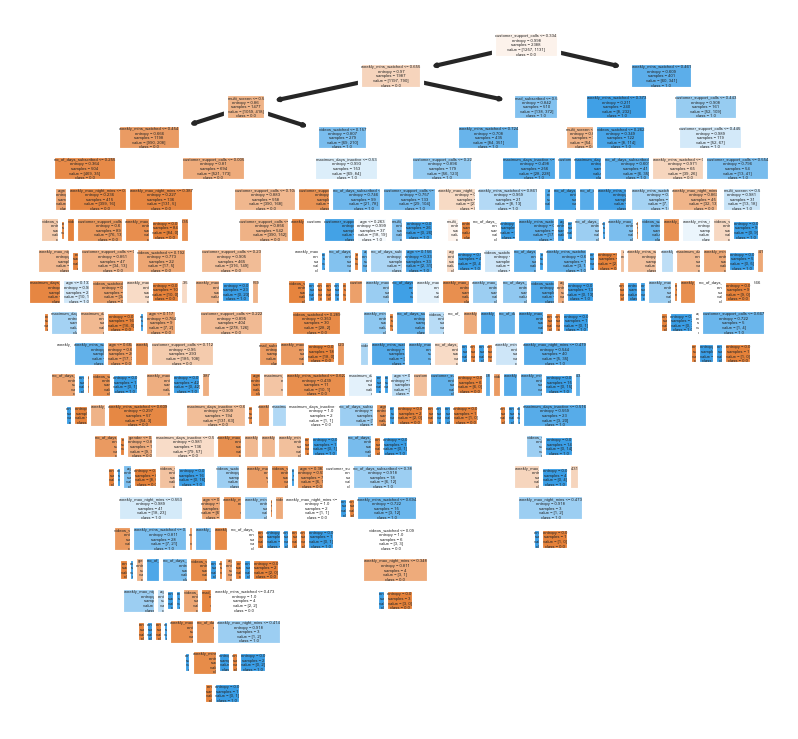

In [43]:
fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (3,3), dpi=300)
tree.plot_tree(clf1,
               feature_names = X_train_resampled.columns, 
               class_names=np.unique(y).astype('str'),
               filled = True)
plt.show()

In [44]:
y_preds = clf1.predict(X_test_full)

print('Accuracy: ', accuracy_score(y_test, y_preds))
print('Precision: ', precision_score(y_test, y_preds))
print('Recall: ', recall_score(y_test, y_preds))
print('F1 Score: ', f1_score(y_test, y_preds))

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_preds)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('ROC AUC:', roc_auc)

Accuracy:  0.5
Precision:  0.18021201413427562
Recall:  0.8225806451612904
F1 Score:  0.2956521739130435
ROC AUC: 0.6377054169202678


The baseline model is not great. The AUC for the ROC curve is low also (nearly .66). Though recall is high relative to the baseline logistic regression, all other metrics are low and the F1 Score makes the model unusable. Next, begin tuning hyperparameters and prune the tree.

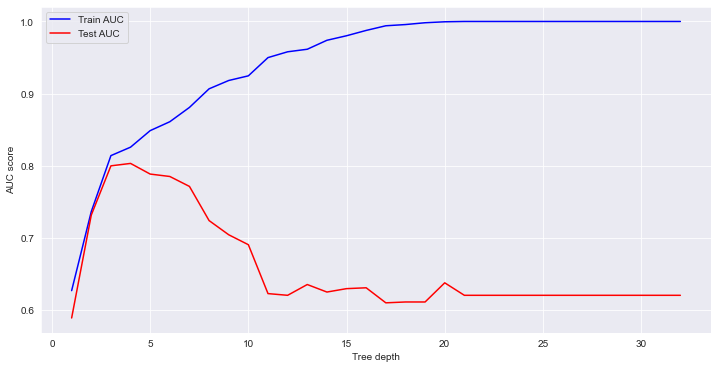

In [45]:
# Identify the optimal tree depth for given data
max_depths = list(range(1, 33))
train_results = []
test_results = []
for max_depth in max_depths:
    dt = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=42)
    dt.fit(X_train_resampled, y_train_resampled)
    train_pred = dt.predict(X_train_resampled)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_resampled, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous train results
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test_full)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous test results
    test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(max_depths, train_results, 'b', label='Train AUC')
plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.legend()
plt.show()

While the training error decreases as the tree becomes more complex (overfit), The test error increases (diminished AUC score) for a tree past depth of 4.

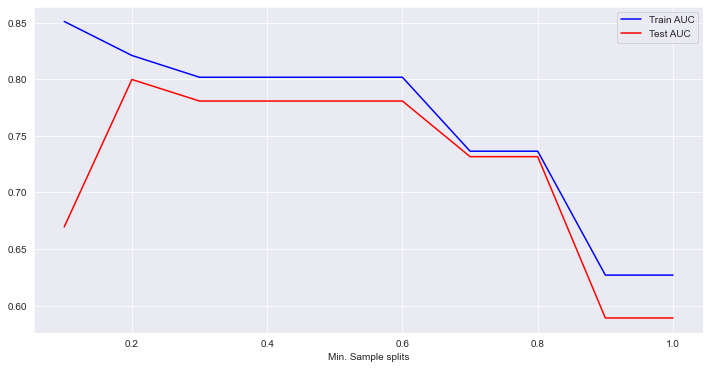

In [46]:
# Identify the optimal min-samples-split for given data
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(criterion='entropy', min_samples_split=min_samples_split, random_state=42)
    dt.fit(X_train_resampled, y_train_resampled)
    train_pred = dt.predict(X_train_resampled)
    false_positive_rate, true_positive_rate, thresholds =    roc_curve(y_train_resampled, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test_full)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.xlabel('Min. Sample splits')
plt.legend()
plt.show()

The AUC for both test and train sets is stable from .3 to .6, and then drops significantly after. The optimal sample split is some value between .3 and .6. 

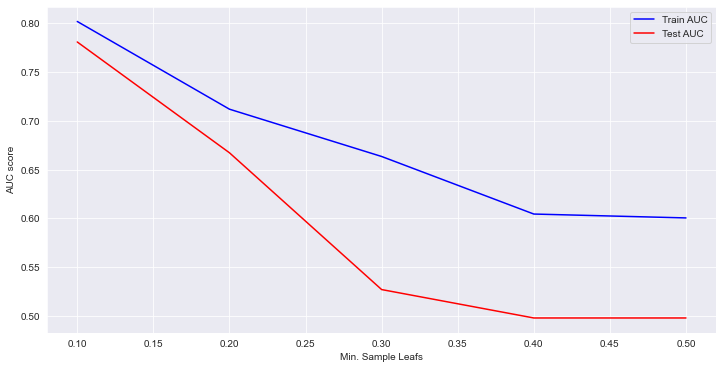

In [47]:
# Calculate the optimal value for minimum sample leafs
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    dt = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=min_samples_leaf, random_state=42)
    dt.fit(X_train_resampled, y_train_resampled)
    train_pred = dt.predict(X_train_resampled)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_resampled, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test_full)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
plt.figure(figsize=(12,6))    
plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('Min. Sample Leafs')
plt.legend()
plt.show()

The AUC is highest at the initial point, .1. Anything greater than this lowers AUC for the ROC. 

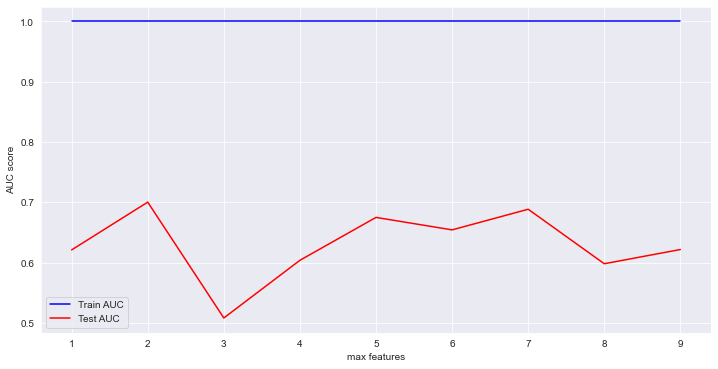

In [48]:
# Find the best value for optimal maximum feature size
max_features = list(range(1, X_train_resampled.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
    dt = DecisionTreeClassifier(criterion='entropy', max_features=max_feature, random_state=42)
    dt.fit(X_train_resampled, y_train_resampled)
    train_pred = dt.predict(X_train_resampled)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_resampled, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test_full)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(max_features, train_results, 'b', label='Train AUC')
plt.plot(max_features, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.legend()
plt.show()

Highest AUC for the test dataset seen between 5 and 7 features. 

Use the determined values to retrain a decision tree with the hyperparameters identified above:

In [65]:
# Train a classifier with optimal values identified above
dt = DecisionTreeClassifier(criterion='entropy',
                           max_features=7,
                           max_depth=4,
                           min_samples_split=0.6,
                           min_samples_leaf=0.1, 
                           random_state=42)
dt.fit(X_train_resampled, y_train_resampled)
y_pred = dt.predict(X_test_full)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC:', roc_auc)

Accuracy:  0.7119341563786008
Precision:  0.2925531914893617
Recall:  0.8870967741935484
F1 Score:  0.44000000000000006
ROC AUC: 0.7867087644552648


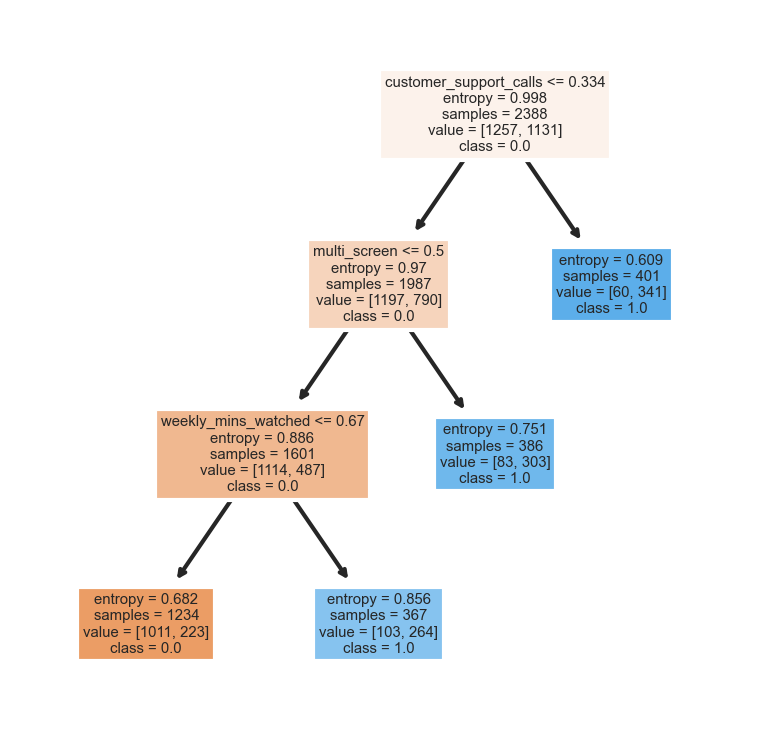

In [66]:
fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (3,3), dpi=300)
tree.plot_tree(dt,
               feature_names = X_train_resampled.columns, 
               class_names=np.unique(y).astype('str'),
               filled = True)
plt.show()

After pruning the tree and setting some hyperparameters, the decision tree has improved recall (from nearly .76 to .89), accuracy (from .58 to .71), F1 Score (from .32 to .79), and ROC AUC (from .66 to .79). 

In [67]:
feature_importances = dt.feature_importances_

# Create a DataFrame to associate feature names with their importances
feature_importance_df = pd.DataFrame({'Feature': X_train_resampled.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print or visualize the top features
print(feature_importance_df.head())

                  Feature  Importance
2     weekly_mins_watched    0.380008
8            multi_screen    0.313543
6  customer_support_calls    0.306449
0                     age    0.000000
1   no_of_days_subscribed    0.000000


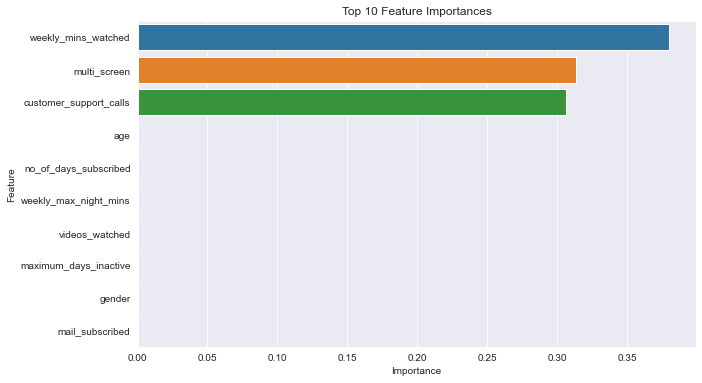

In [68]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Top 10 Feature Importances')
plt.show()

The most important features that determine whether a customer churns or not are 'weekly_mins_watched', 'multi_screen', and 'customer_support_calls.' When providing a streaming platform with recommendations on how to retain customers, emphasize strategies that relate to these three features. 